In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data'
        self.datasetG= 'masked_pwc'
        self.datasetD= 'pwc'
        self.batch_size= 128
        self.model= 'unet1d'
        self.modelG= 'unet1d'
        self.modelD= 'gan_discriminator'
        self.lr= 0.001
        self.num_epochs= 10
        self.n_data = 1000
        self.min_sep = 5
        self.valid_interval= 2
        self.save_interval= 2
        self.seed = 0
        self.output_dir= 'experiments'
        self.experiment= None

        self.resume_training= False
        self.restore_file= None

        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False

        self.in_channels= 1
        self.hidden_size = 64
        self.bias= False
        self.test_num = 0
        self.wtl2 = 0 # l2 loss weighting
        # UNET
        self.residual = False
args=Args()

In [3]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
utils.setup_experiment(args)
utils.init_logging(args)

[2020-09-01 10:52:03] COMMAND: /home/michael/python-virtual-environments/bfcnn/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-7c3ae58b-dfca-4b8b-b647-df8a4c6f497a.json
[2020-09-01 10:52:03] Arguments: {'data_path': 'data', 'datasetG': 'masked_pwc', 'datasetD': 'pwc', 'batch_size': 128, 'model': 'unet1d', 'modelG': 'unet1d', 'modelD': 'gan_discriminator', 'lr': 0.001, 'num_epochs': 10, 'n_data': 1000, 'min_sep': 5, 'valid_interval': 2, 'save_interval': 2, 'seed': 0, 'output_dir': 'experiments', 'experiment': 'unet1d-Sep-01-10:52:03', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': False, 'log_interval': 100, 'no_visual': False, 'visual_interval': 100, 'no_progress': False, 'draft': False, 'dry_run': False, 'in_channels': 1, 'hidden_size': 64, 'bias': False, 'test_num': 0, 'wtl2': 0, 'residual': False, 'experiment_dir': 'experiments/unet1d/unet1d-Sep-01-10:52:03', 'checkpoint_di

### Define models and optimizers

In [4]:
G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

G_PATH = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
D_PATH = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
netG.load_state_dict(torch.load(G_PATH))
netD.load_state_dict(torch.load(D_PATH))

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lr,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lr,betas=(0.5, 0.999))

logging.info(f"Built a generator model consisting of {sum(p.numel() for p in netG.parameters()):,} parameters")
logging.info(f"Built a discriminator model consisting of {sum(p.numel() for p in netD.parameters()):,} parameters")

global_step = -1
start_epoch = 0

[2020-09-01 10:52:05] Built a generator model consisting of 72,000 parameters
[2020-09-01 10:52:05] Built a discriminator model consisting of 692,224 parameters


In [5]:
# Build data loaders, a model and an optimizer

G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

G_PATH = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
D_path = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
netG.load_state_dict(torch.load(G_PATH))
netD.load_state_dict(torch.load(D_PATH))

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lr,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lr,betas=(0.5, 0.999))

logging.info(f"Built a generator model consisting of {sum(p.numel() for p in netG.parameters()):,} parameters")
logging.info(f"Built a discriminator model consisting of {sum(p.numel() for p in netD.parameters()):,} parameters")

if args.resume_training and args.restore_file is not None:
    state_dict = utils.load_checkpoint_GAN(args, netG, netD, optimizerG, optimizerD)
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-09-01 10:52:05] Built a generator model consisting of 72,000 parameters
[2020-09-01 10:52:05] Built a discriminator model consisting of 692,224 parameters


In [6]:
# build_dataset is a function in utils/data/__init__.py
train_loaderG, valid_loaderG, _ = data.build_dataset(args.datasetG,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)
train_loaderD, _, _ = data.build_dataset(args.datasetD,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

In [7]:
# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss", "train_psnr", "train_ssim"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_psnr", "valid_ssim"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

epoch 00:  12%|█▎        | 1/8 [00:00<00:01,  4.54it/s, train_loss=0.904 (0.985), train_psnr=15.869 (16.469), train_ssim=0.810 (0.807), lr=1.0e-03]

[0/10][0/8]	Loss_D: 1.4117	Loss_G: 0.9028	D(x): 0.4396	D(G(z)): 0.3814 / 0.4424


[2020-09-01 10:52:32] epoch 00 | train_loss 0.911 | train_psnr 16.474 | train_ssim 0.814 | valid_psnr 23.242 | valid_ssim 0.857 | lr 1.0e-03       
epoch 01:  25%|██▌       | 2/8 [00:00<00:01,  5.71it/s, train_loss=0.887 (0.696), train_psnr=23.579 (22.638), train_ssim=0.859 (0.858), lr=1.0e-03]

[1/10][0/8]	Loss_D: 1.5168	Loss_G: 0.8911	D(x): 0.4935	D(G(z)): 0.5155 / 0.4264


epoch 02:  25%|██▌       | 2/8 [00:00<00:01,  5.54it/s, train_loss=0.844 (0.784), train_psnr=21.644 (20.862), train_ssim=0.847 (0.834), lr=1.0e-03]

[2/10][0/8]	Loss_D: 1.4292	Loss_G: 0.8449	D(x): 0.4919	D(G(z)): 0.4770 / 0.4486


[2020-09-01 10:52:38] epoch 02 | train_loss 0.838 | train_psnr 21.921 | train_ssim 0.849 | valid_psnr 23.648 | valid_ssim 0.857 | lr 1.0e-03       
epoch 03:  12%|█▎        | 1/8 [00:00<00:01,  4.82it/s, train_loss=0.798 (0.784), train_psnr=24.983 (22.215), train_ssim=0.864 (0.849), lr=1.0e-03]

[3/10][0/8]	Loss_D: 1.3918	Loss_G: 0.7980	D(x): 0.5131	D(G(z)): 0.4947 / 0.4665


epoch 04:  25%|██▌       | 2/8 [00:00<00:01,  5.60it/s, train_loss=0.717 (0.814), train_psnr=23.857 (23.718), train_ssim=0.872 (0.858), lr=1.0e-03]

[4/10][0/8]	Loss_D: 1.4804	Loss_G: 0.7150	D(x): 0.4944	D(G(z)): 0.5145 / 0.4990


[2020-09-01 10:52:43] epoch 04 | train_loss 0.723 | train_psnr 23.670 | train_ssim 0.869 | valid_psnr 24.718 | valid_ssim 0.871 | lr 1.0e-03       
epoch 05:  12%|█▎        | 1/8 [00:00<00:01,  4.86it/s, train_loss=0.782 (0.766), train_psnr=24.276 (23.878), train_ssim=0.875 (0.868), lr=1.0e-03]

[5/10][0/8]	Loss_D: 1.3990	Loss_G: 0.7820	D(x): 0.5010	D(G(z)): 0.4777 / 0.4725


epoch 06:  25%|██▌       | 2/8 [00:00<00:01,  5.56it/s, train_loss=0.744 (0.733), train_psnr=22.849 (24.152), train_ssim=0.865 (0.874), lr=1.0e-03]

[6/10][0/8]	Loss_D: 1.3979	Loss_G: 0.7446	D(x): 0.5260	D(G(z)): 0.5181 / 0.4805


[2020-09-01 10:52:49] epoch 06 | train_loss 0.749 | train_psnr 23.032 | train_ssim 0.865 | valid_psnr 23.841 | valid_ssim 0.860 | lr 1.0e-03       
epoch 07:  12%|█▎        | 1/8 [00:00<00:01,  4.81it/s, train_loss=0.760 (0.797), train_psnr=23.682 (25.269), train_ssim=0.862 (0.879), lr=1.0e-03]

[7/10][0/8]	Loss_D: 1.4344	Loss_G: 0.7597	D(x): 0.4765	D(G(z)): 0.4746 / 0.4766


epoch 08:  25%|██▌       | 2/8 [00:00<00:01,  5.63it/s, train_loss=0.767 (0.731), train_psnr=24.304 (23.905), train_ssim=0.874 (0.875), lr=1.0e-03]

[8/10][0/8]	Loss_D: 1.4307	Loss_G: 0.7682	D(x): 0.4919	D(G(z)): 0.4762 / 0.4749


[2020-09-01 10:52:55] epoch 08 | train_loss 0.765 | train_psnr 23.896 | train_ssim 0.871 | valid_psnr 18.746 | valid_ssim 0.832 | lr 1.0e-03       
epoch 09:  12%|█▎        | 1/8 [00:00<00:01,  4.74it/s, train_loss=0.798 (0.859), train_psnr=19.023 (18.782), train_ssim=0.832 (0.829), lr=1.0e-03]

[9/10][0/8]	Loss_D: 1.3739	Loss_G: 0.7967	D(x): 0.5628	D(G(z)): 0.5389 / 0.4560


[2020-09-01 10:52:56] Done training!                                                                                                               


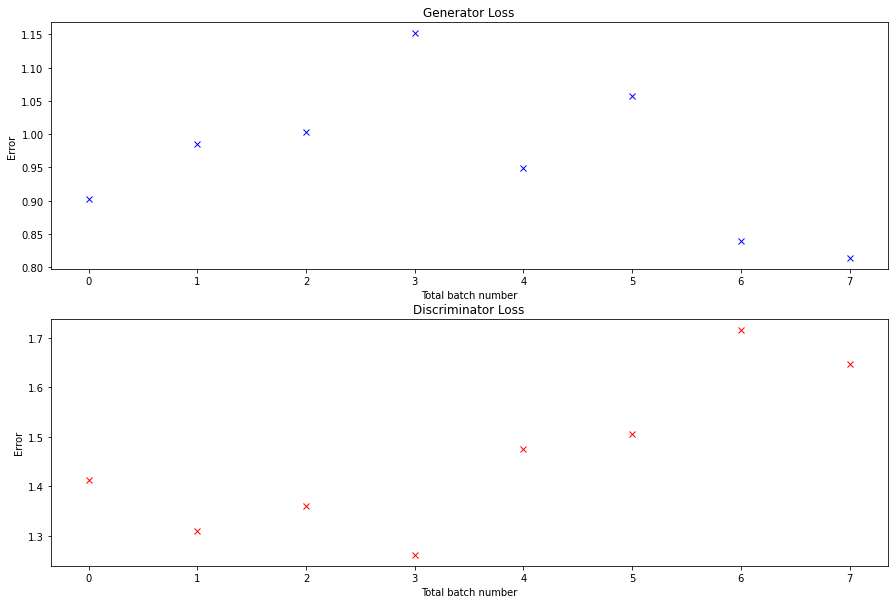

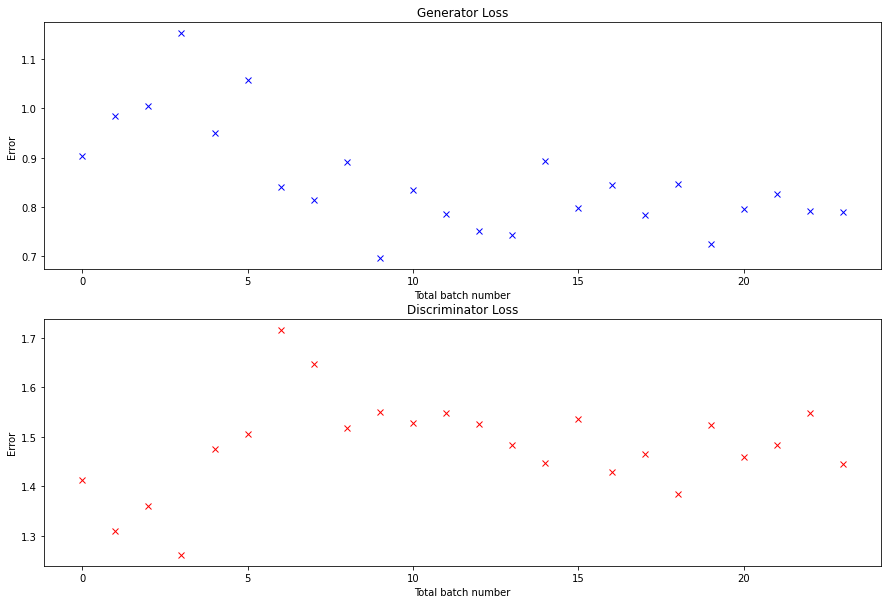

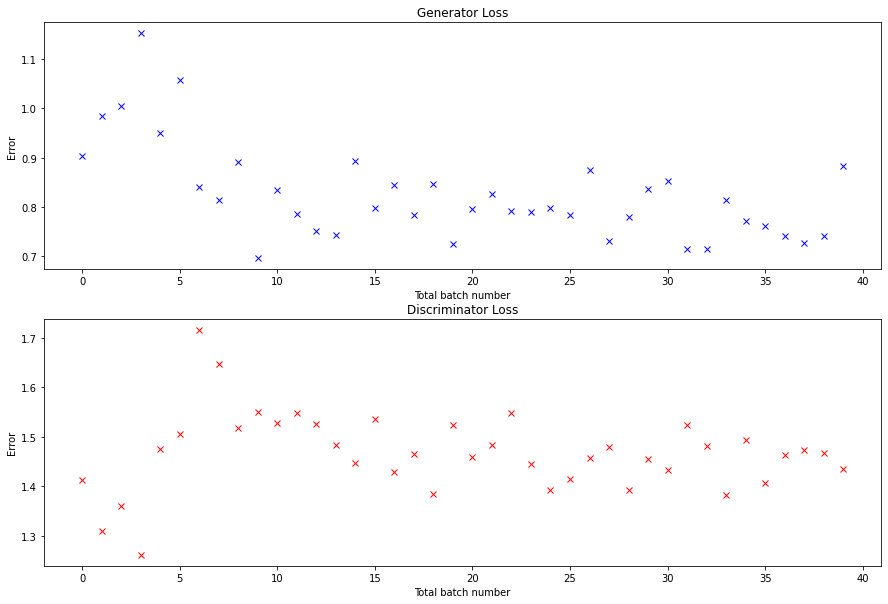

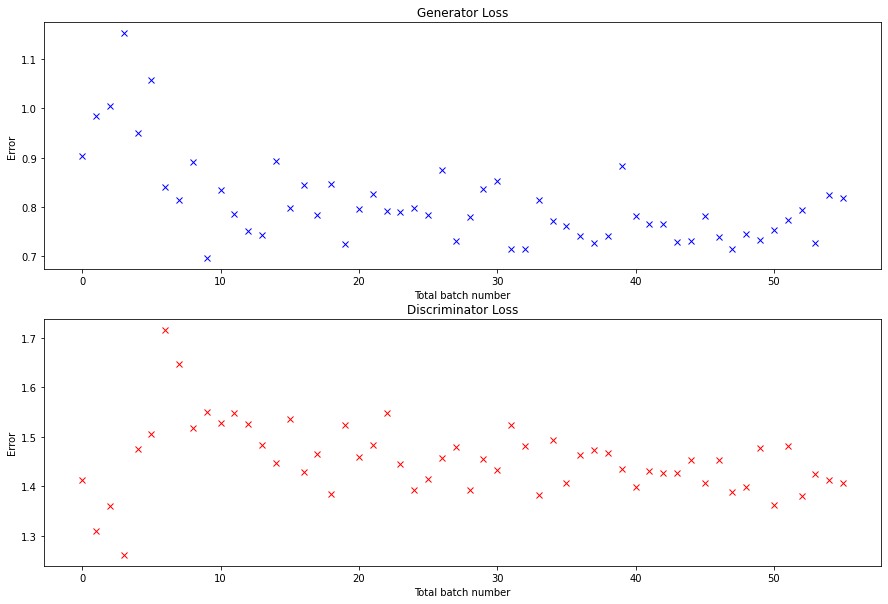

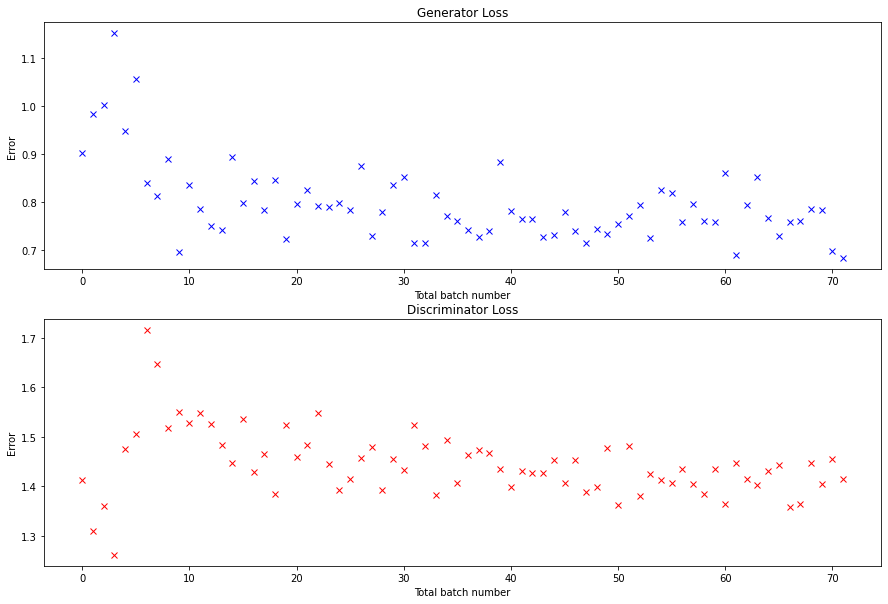

In [9]:
fake_label = 0.
real_label = 1.
# fake_label = [0.,0.1]
# real_label = [0.9,1.]

G_losses = []
D_losses = []

if args.wtl2 > 0:
    use_mse = True
else:
    use_mse = False



# TRAINING
for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %10 == 0:
            optimizerG.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loaderG, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, ((clean, mask),real) in enumerate(zip(train_bar,train_loaderD)):
        
        ###############################
        # First train the discriminator
        ###############################
        netD.zero_grad()
        real_cpu = real.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,),real_label,device=device)
        # Introducing label noise
#         label = torch.rand((b_size,),device=device)*(real_label[1]-real_label[0])+real_label[0]

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate fake signal batch with G
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = netG(inputs,mask_inputs)
        fake = (1-mask_inputs)*raw_outputs + mask_inputs*inputs
        
        label.fill_(fake_label)
        # Introducing label noise
#         label = torch.rand((b_size,),device=device)*(fake_label[1]-fake_label[0])+fake_label[0]

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ###############################
        # Next, train the generator
        ###############################
        netG.zero_grad() # train() or zero_grad()?
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        if use_mse:
            # Calculate G's loss based on this output
            errG_D = criterion(output, label)
            # MSE Loss
            errG_l2 = F.mse_loss(fake, inputs, reduction="sum") / (inputs.size(0) * 2)
            errG =  (1-args.wtl2) * errG_D + args.wtl2 * errG_l2
        else:
            errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        

        
        # Output training stats
        if batch_id % 50 == 0:
            if use_mse:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f + %.4f = %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG), \
                     errD.item(), errG_D.item(), errG_l2, errG.item(), D_x, D_G_z1, D_G_z2))
            else: 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # TO DO: add a "fixed input" to check in on G over time
#         if (global_step % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloaderG)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        global_step += 1
        
        # TO DO, only run loss on masked part of output
        # TO DO, incorporate MSE loss into GAN?
#         loss = F.mse_loss(outputs, inputs, reduction="sum") / (inputs.size(0) * 2)

        train_psnr = utils.psnr(fake, inputs)
        train_ssim = utils.ssim(fake, inputs)
        train_meters["train_loss"].update(errG.item())
        train_meters["train_psnr"].update(train_psnr.item())
        train_meters["train_ssim"].update(train_ssim.item())
        train_bar.log(dict(**train_meters, lr=optimizerG.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizerG.param_groups[0]["lr"], global_step)
            writer.add_scalar("loss/train", errG.item(), global_step)
            writer.add_scalar("psnr/train", train_psnr.item(), global_step)
            writer.add_scalar("ssim/train", train_ssim.item(), global_step)
            gradients = torch.cat([p.grad.view(-1) for p in netG.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()

    if epoch % args.valid_interval == 0:
        netG.eval()
        for meter in valid_meters.values():
            meter.reset()

        valid_bar = utils.ProgressBar(valid_loaderG)
        
        for sample_id, (clean, mask) in enumerate(valid_bar):
            with torch.no_grad():
                inputs = clean.to(device)
                mask_inputs = mask.to(device)
                # only use the mask part of the outputs
                raw_output = netG(inputs,mask_inputs)
                output = (1-mask_inputs)*raw_output + mask_inputs*inputs
                valid_psnr = utils.psnr(inputs, output)
                valid_meters["valid_psnr"].update(valid_psnr.item())
                valid_ssim = utils.ssim(inputs, output)
                valid_meters["valid_ssim"].update(valid_ssim.item())

        if writer is not None:
            writer.add_scalar("psnr/valid", valid_meters['valid_psnr'].avg, global_step)
            writer.add_scalar("ssim/valid", valid_meters['valid_ssim'].avg, global_step)
            sys.stdout.flush()
            utils.save_checkpoint_GAN(args, global_step, netG, netD, optimizerG, optimizerD, score=valid_meters["valid_psnr"].avg, mode="max")

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizerG.param_groups[0]["lr"])))
        # Save the loss curve plot
    utils.save_losses_curve(G_losses,D_losses,args)
# logging.info(f"Done training! Best PSNR {utils.save_checkpoint_GAN.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")
logging.info(f"Done training!")

In [22]:
save_checkpoint_GAN(args, global_step, netG, netD, \
                          optimizerG, optimizerD, score=valid_meters["valid_psnr"].avg, mode="max")

step:  87


In [21]:
def save_checkpoint_GAN(args, step, modelG, modelD, optimizerG=None, optimizerD=None, scheduler=None, score=None, mode="min"):
    assert mode == "min" or mode == "max"
    last_step = getattr(save_checkpoint_GAN, "last_step", -1)
    save_checkpoint_GAN.last_step = max(last_step, step)

    default_score = float("inf") if mode == "min" else float("-inf")
    best_score = getattr(save_checkpoint_GAN, "best_score", default_score)
    if (score < best_score and mode == "min") or (score > best_score and mode == "max"):
        save_checkpoint_GAN.best_step = step
        save_checkpoint_GAN.best_score = score
    print("step: ",step)
    if not args.no_save and step % args.save_interval == 0:
        os.makedirs(args.checkpoint_dir, exist_ok=True)
        modelG = [modelG] if modelG is not None and not isinstance(modelG, list) else modelG
        modelD = [modelD] if modelD is not None and not isinstance(modelD, list) else modelD
        optimizerG = [optimizerG] if optimizerG is not None and not isinstance(optimizerG, list) else optimizerG
        optimizerD = [optimizerD] if optimizerD is not None and not isinstance(optimizerD, list) else optimizerD
        scheduler = [scheduler] if scheduler is not None and not isinstance(scheduler, list) else scheduler
        state_dict = {
            "step": step,
            "score": score,
            "last_step": save_checkpoint_GAN.last_step,
            "best_step": save_checkpoint_GAN.best_step,
            "best_score": getattr(save_checkpoint_GAN, "best_score", None),
            "modelG": [m.state_dict() for m in modelG] if modelG is not None else None,
            "modelD": [m.state_dict() for m in modelD] if modelD is not None else None,
            "optimizerG": [o.state_dict() for o in optimizerG] if optimizerG is not None else None,
            "optimizerD": [o.state_dict() for o in optimizerD] if optimizerD is not None else None,
            "scheduler": [s.state_dict() for s in scheduler] if scheduler is not None else None,
            "args": argparse.Namespace(**{k: v for k, v in vars(args).items() if not callable(v)}),
        }
        print("best score: ",best_score)

        if args.step_checkpoints:
            torch.save(state_dict, os.path.join(args.checkpoint_dir, "checkpoint{}.pt".format(step)))
        if (score < best_score and mode == "min") or (score > best_score and mode == "max"):
            torch.save(state_dict, os.path.join(args.checkpoint_dir, "checkpoint_best.pt"))
        if step > last_step:
            torch.save(state_dict, os.path.join(args.checkpoint_dir, "checkpoint_last.pt"))

In [ ]:
save_losses_curve(G_losses,D_losses)

### Testing

In [ ]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def print_one(loader,model1,model2):
    np.random.seed()
    clean,mask = next(iter(loader))
    outputs1 = model1(clean.to(device),mask.to(device)).cpu()
    outputs2 = model2(clean.to(device),mask.to(device)).cpu()
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    out1 = outputs1[0] * (1-mask[0]) + clean[0]*mask[0]
    out2 = outputs2[0] * (1-mask[0]) + clean[0]*mask[0]

    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[15,14])
    plt.subplot(4,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(4,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("Masked signal")

    plt.subplot(4,1,3)
    plt.plot(out1[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("GAN denoised signal")
    print(outputs1[0,:].detach())
    
    plt.subplot(4,1,4)
    plt.plot(out2[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("MSE denoised signal")
#     return out1,out2, clean

In [ ]:
# Load MSE model
mse = models.build_model(args)
netMSE = mse.to(device)

MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_3minsep_08_14_20.pth"
netMSE.load_state_dict(torch.load(MODEL_PATH))
netMSE.to(device)

In [ ]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.datasetG,
                                                   1000, 
                                                   batch_size=1,
                                                   fix_datapoints=False,
                                                   min_sep = args.min_sep,
                                                   test_num = 2)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
len(D_losses)

In [ ]:
## Saving the model
MODEL_PATHG = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
MODEL_PATHD = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
torch.save(netG.state_dict(), MODEL_PATHG)
torch.save(netD.state_dict(), MODEL_PATHD)